In [1]:
import numpy as np
import mne
import scipy.signal as sg
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import seaborn as sns
import stumpy

c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Load Data Information

In [2]:
#Load a single patient that will be used for analysis
file = "./DatabaseSubjects\subject1.edf"
anno = "./DatabaseSubjects/HypnogramAASM_subject1.txt"
#anno = "C:/Users/Rafael Arone/DOwnloads/c52a34.csv"
data = mne.io.read_raw_edf(file, preload=True)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names
print("Loaded")

Extracting EDF parameters from c:\Users\rafar\Documents\2024\Disciplina - Machine Learning Para séries Temporais\Trabalho1\DatabaseSubjects\subject1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\rafar\AppData\Local\Temp\ipykernel_34700\1430877535.py:5: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  data = mne.io.read_raw_edf(file, preload=True)
c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\mne\io\edf\edf.py:782: RuntimeWarning: All-NaN axis encountered
  value = np.nanmax([_prefilter_float(x) for x in values])
C:\Users\rafar\AppData\Local\Temp\ipykernel_34700\1430877535.py:5: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  data = mne.io.read_raw_edf(file, preload=True)
c:\Users\rafar\miniconda3\envs\torch_env\lib\site-packages\mne\io\edf\edf.py:784: RuntimeWarning: All-NaN axis encountered
  value = np.nanmin([_prefilter_float(x) for x in values])


Reading 0 ... 5767999  =      0.000 ... 28839.995 secs...
Loaded


In [3]:
##Read annotations from the txt file with single column
def read_annotations(file):
    with open(file, 'r') as f:
        annotations = f.readlines()
    annotations = [int(x.strip()) for x in annotations[1:]]
    return annotations

annotations = read_annotations(anno)


In [4]:
#Dataset information
info

<Info | 8 non-empty values
 bads: []
 ch_names: ECG, FP1-A2, CZ-A1, EMG1, EOG1, VTH, VAB, NAF2P-A1, NAF1, PHONO, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2002-05-29 22:55:00 UTC
 nchan: 23
 projs: []
 sfreq: 200.0 Hz
 subject_info: 3 items (dict)
>

In [5]:
fs = info['sfreq'] #Hz
segmentation_size = 5*fs #30 seconds
num_channels = len(channels)

In [6]:
##Perform filtering to downsample
#Filter until 25Hz to downsample in 50Hz (Nyquist frequency)
fs = int(info['sfreq']) #Hz
segmentation_size = 5*fs #30 seconds
data.filter(0.5, 25, fir_design='firwin')
raw_data = data.get_data()
#Downsample from 200Hz to 50Hz
raw_data = sg.decimate(raw_data, 4, axis=1)
fs = fs/4


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


In [7]:
#Get rhe CZ-A1 channel
offset = int(30*60*fs)
interest_channels = ['EOG2']
indexes  = [channels.index(x) for x in interest_channels]
channel = raw_data[indexes]
#Remove the last 30 minutes of data
raw_data = raw_data[..., :-offset]

In [8]:
gt = np.array(annotations)
#Remove the last hout
gt = gt[:-int(offset/(5*fs))]

In [9]:
#Perform z-normalization
channel_means = np.mean(raw_data, axis=1)   
channel_std = np.std(raw_data, axis=1)
raw_data = (raw_data - channel_means[:, np.newaxis])/channel_std[:, np.newaxis]
channel = raw_data[0]

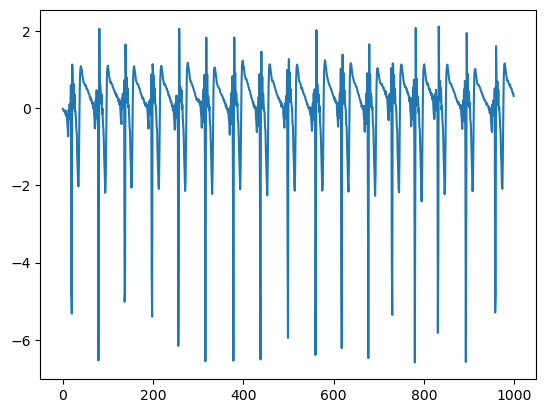

In [11]:
plt.plot(channel[:int(fs*20)])

In [11]:
fs

50.0

In [12]:
#Analysis using matrix profile
import stumpy

segmentation_size = int(2*fs)
out = stumpy.gpu_stump(channel, m=int(segmentation_size))


In [13]:
class_name_alias = {
    0: 'dont_care',
    1: 'N3',
    2: 'N2',
    3: 'N1',
    4: 'REM',
    5: 'A',
}

In [14]:
#Use the dict to change the labels
gt = np.array([class_name_alias[x] for x in gt])

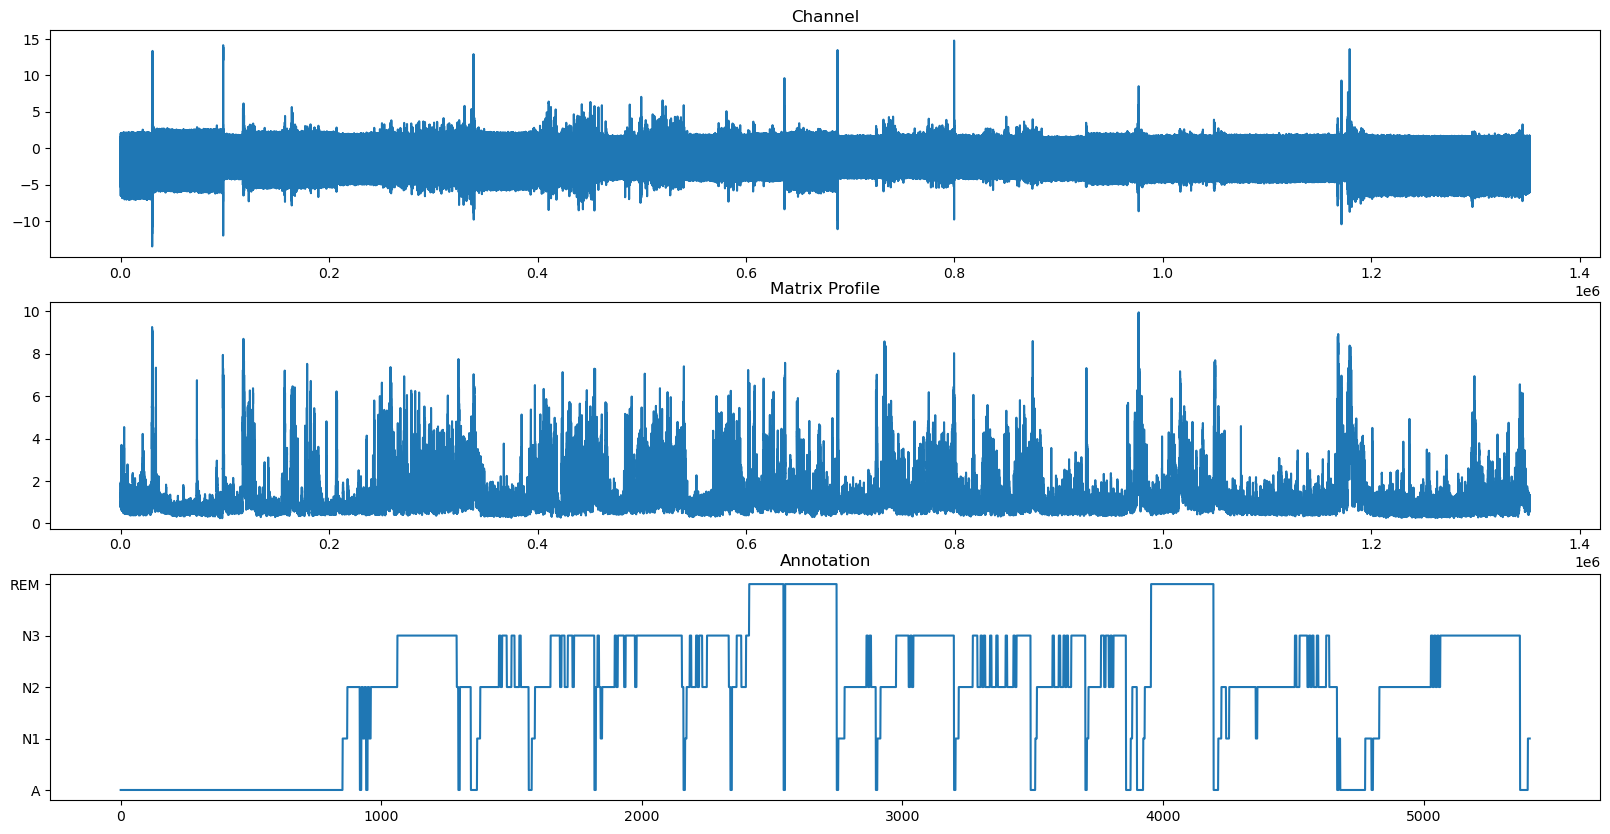

In [15]:
#Plot matrix profile with the ground truth in different subplots
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(channel)
plt.title("Channel")
plt.subplot(3, 1, 2)
plt.title("Matrix Profile")
plt.plot(out[:, 0])
plt.subplot(3, 1, 3)
plt.title("Annotation")
#Change annotation to the class_name alias
#gt_alias = [class_name_alias[x] for x in gt]
plt.plot(gt)
plt.show()





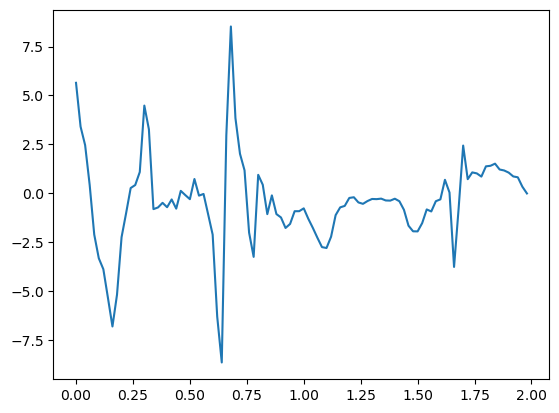

In [16]:
#Get the discord (position of the most anomalous segment)
discord = np.argmax(out[:,0])	
t = np.arange(0,segmentation_size)/fs
plt.plot(t,channel[discord:discord+segmentation_size])

Text(0, 0.5, 'Amplitude')

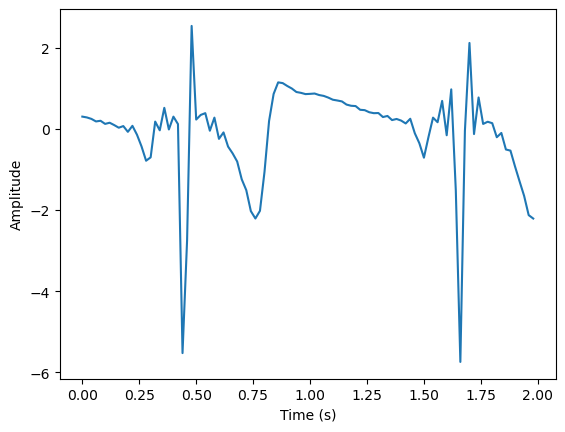

In [17]:
#Plot one motif
motif = np.argmin(out[:,0])
plt.plot(t,channel[motif:motif+segmentation_size])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')



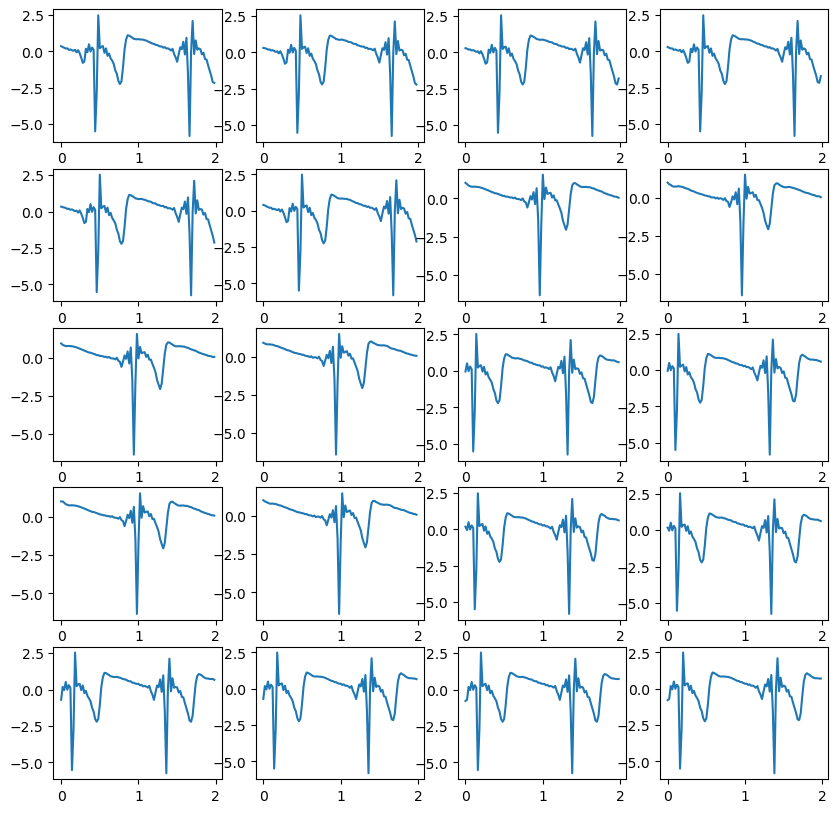

In [18]:
#Plot the first 10 motifs
motifs = np.argsort(out[:,0])[0:20]
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(20):
    axs[i].plot(t,channel[motifs[i]:motifs[i]+segmentation_size])
plt.show()


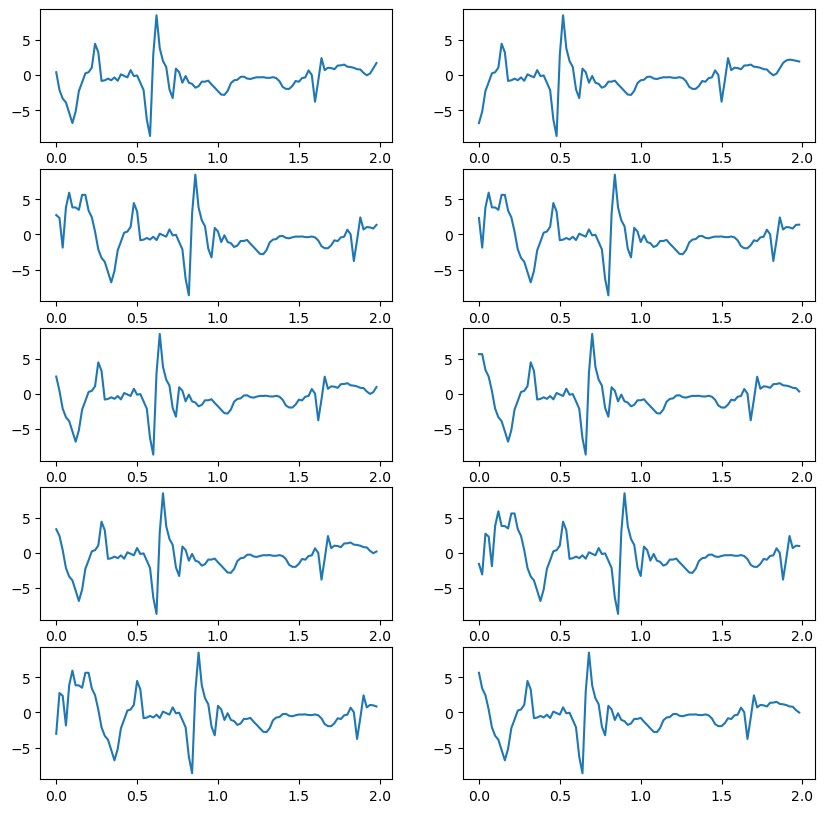

In [19]:
#Plot the first 10 discords
discords = np.argsort(out[:,0])[-10:]
fig, axs = plt.subplots(5, 2, figsize=(10, 10))
axs = axs.ravel()
for i in range(10):
    axs[i].plot(t,channel[discords[i]:discords[i]+segmentation_size])
plt.show()


In [16]:
out

mparray([[5.957885729557112, 288629, -1, 288629],
         [5.8461972833598415, 1379227, -1, 1379227],
         [5.712819700664142, 1379228, -1, 1379228],
         ...,
         [9.37881872245844, 471994, 471994, -1],
         [9.373908691937793, 471995, 471995, -1],
         [9.385213670467891, 471996, 471996, -1]], dtype=object)

In [20]:
#Get different motifs, for the motifs similiar to the first one add a oofset, and recalculate the motifs, until we reach 10 different mmotifs
out_new = out.copy()
base_motifs = []
num_diff_motifs = 20
offset_to_add = 20
passed_motifs = []

def change_motif_offset(out_new, index_motif, offset_to_add, depth = 0, max_depth = 50):
    #Get motifs similar to the base motif by using the second from out_new
    #Check for the left and right indexes motifs
    if depth > max_depth:
        return
    if index_motif in passed_motifs[-1]:
        return
    left_index = out_new[index_motif, 2]
    right_index = out_new[index_motif, 3]
    out_new[index_motif, 0] = np.inf
    passed_motifs[-1].append(index_motif)
    #Get unique indexes that are not -1
    indexes_to_check = np.unique(np.concatenate((np.array([left_index]), np.array([right_index]))))
    indexes_to_check = indexes_to_check[indexes_to_check != -1]
    #Remove the passed motifs
    indexes_to_check = np.setdiff1d(indexes_to_check, passed_motifs[-1])

    for index in indexes_to_check:
        change_motif_offset(out_new, index, offset_to_add, depth+1, max_depth)

for i in range(num_diff_motifs):
    index_motif = np.argmin(out_new[:,0])
    base_motifs.append(index_motif)
    passed_motifs.append([])
    print(i)

    change_motif_offset(out_new, index_motif, offset_to_add)
    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


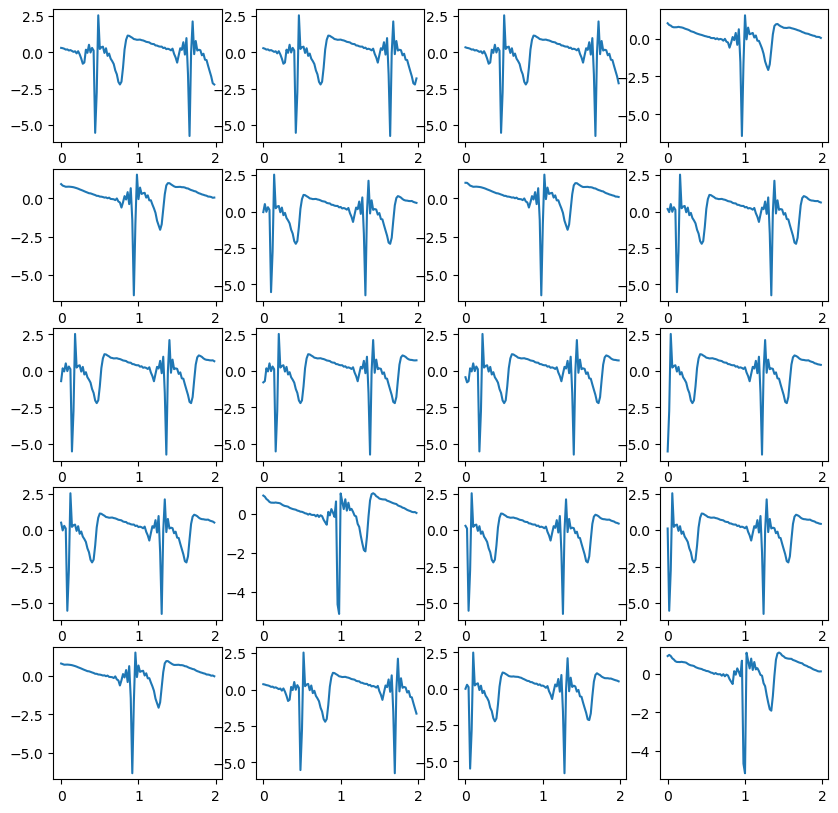

In [21]:
#Plot the base motifs
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(20):
    axs[i].plot(t,channel[base_motifs[i]:base_motifs[i]+segmentation_size])
plt.show()


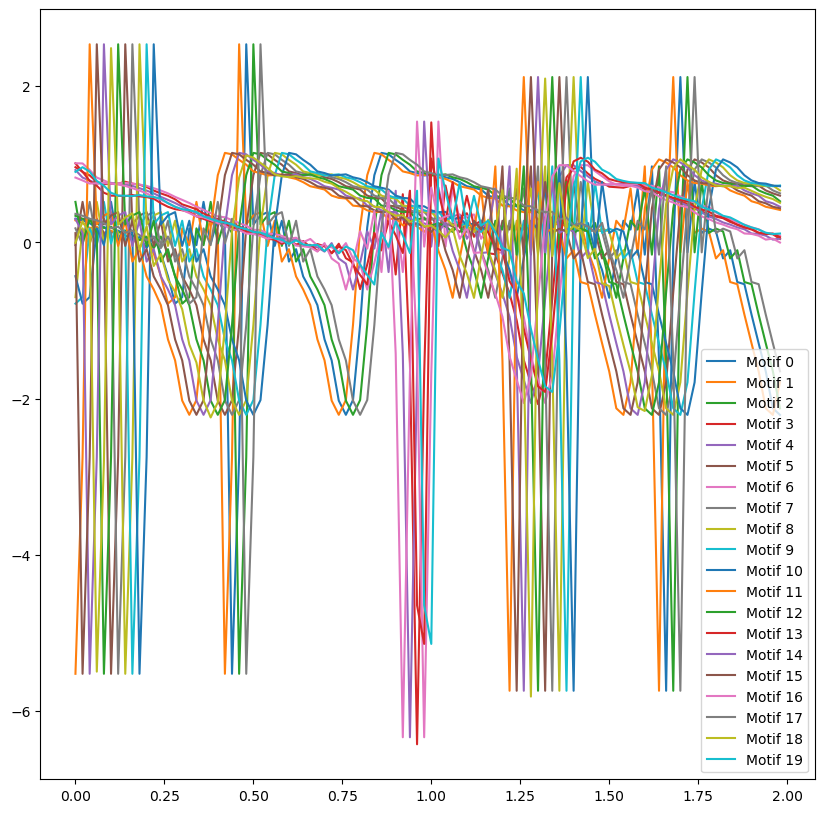

In [22]:
#Plot all in the same graph
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(20):
    ax.plot(t,channel[base_motifs[i]:base_motifs[i]+segmentation_size])
    ax.legend(["Motif "+str(i) for i in range(20)])
plt.show()

In [20]:
#Find the classes from the gt where each motif belongs
classes_by_motif_cluster = []
for passed_motifs_i in passed_motifs:
    classes = []
    for motif in passed_motifs_i:
        classes.append(annotations[int(motif/(30*fs))])
    classes_by_motif_cluster.append(classes)

In [21]:
len(classes)

20103

In [29]:
motif/(5*fs)

3925.692

In [23]:
#Count the number of each class for each motif cluster
count_classes = []
for classes in classes_by_motif_cluster:
    count_classes.append(np.unique(classes, return_counts=True))

In [30]:
np.unique(classes_by_motif_cluster[2])

array([2, 3, 5])

In [31]:
len(classes_by_motif_cluster[2])

30228

In [32]:
count_classes

[(array([2, 3, 5]), array([ 4293,  2120, 23813], dtype=int64)),
 (array([2, 3, 5]), array([ 4085,  2034, 22339], dtype=int64)),
 (array([2, 3, 5]), array([ 4293,  2122, 23813], dtype=int64)),
 (array([2, 3, 5]), array([ 2375,  1382, 13864], dtype=int64)),
 (array([2, 3, 5]), array([ 3662,  1971, 21789], dtype=int64)),
 (array([2, 3, 5]), array([ 2531,  1508, 14919], dtype=int64)),
 (array([2, 3, 5]), array([ 2423,  1405, 13544], dtype=int64)),
 (array([2, 3, 5]), array([ 2432,  1509, 14619], dtype=int64)),
 (array([2, 3, 5]), array([ 2539,  1489, 14743], dtype=int64)),
 (array([2, 3, 5]), array([ 2838,  1679, 17470], dtype=int64)),
 (array([2, 3, 5]), array([ 3636,  1926, 19955], dtype=int64)),
 (array([2, 3, 5]), array([ 3894,  2151, 22934], dtype=int64)),
 (array([2, 3, 5]), array([ 3503,  2076, 20893], dtype=int64)),
 (array([2, 3, 5]), array([ 3756,  1928, 20961], dtype=int64)),
 (array([2, 3, 5]), array([ 3240,  1862, 20131], dtype=int64)),
 (array([2, 3, 5]), array([ 4021,  2112,

In [33]:
int(base_motifs[i]/fs)

28051

In [34]:
base_motifs

[1400028,
 1400269,
 1400029,
 1400032,
 1399961,
 1399979,
 1402333,
 1399978,
 1402346,
 1404365,
 1401981,
 1400357,
 1404270,
 1404367,
 1400352,
 1400361,
 1401982,
 1402590,
 1400362,
 1402591]

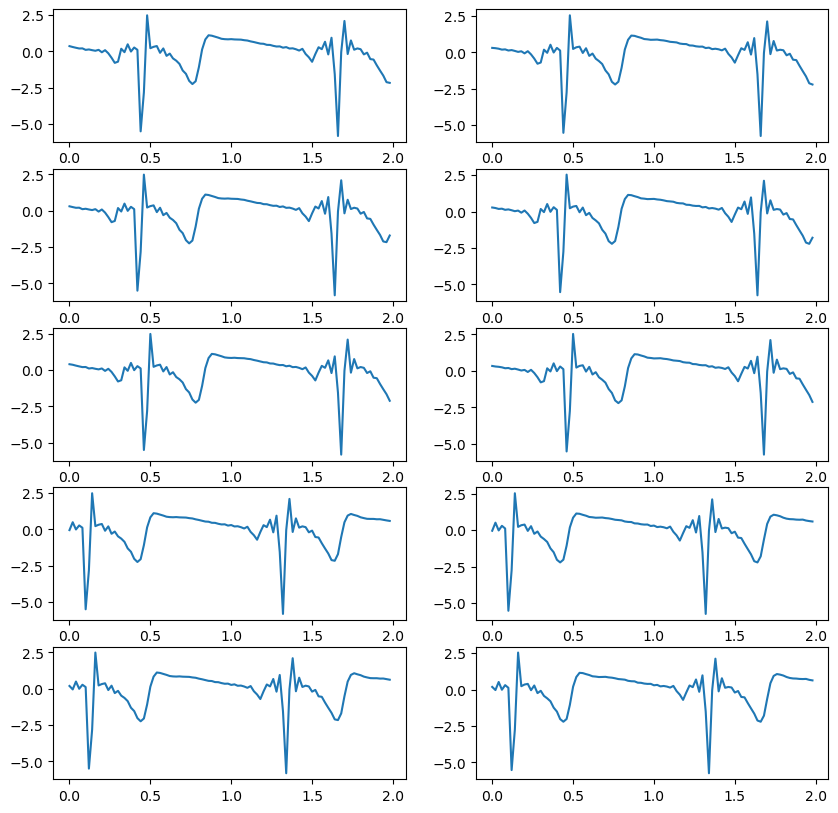

Class:  A


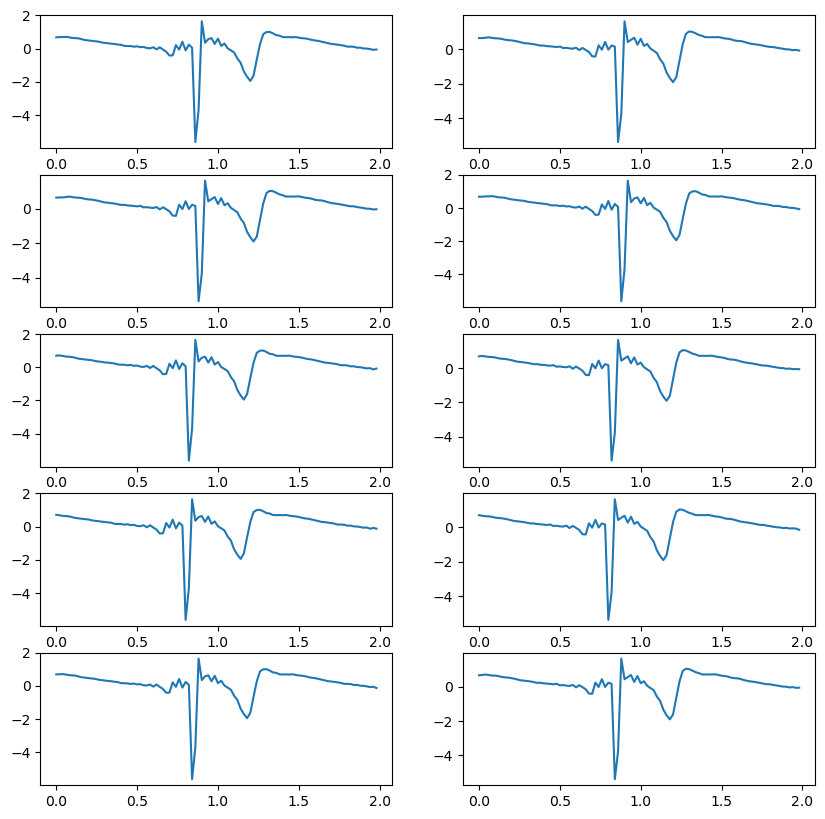

Class:  N1


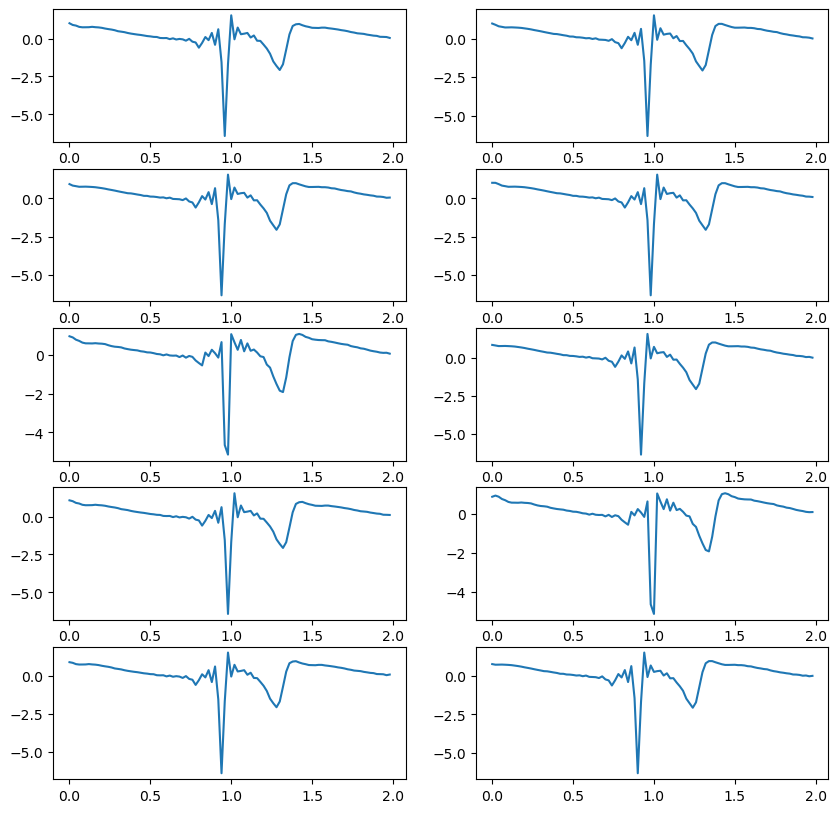

Class:  N2


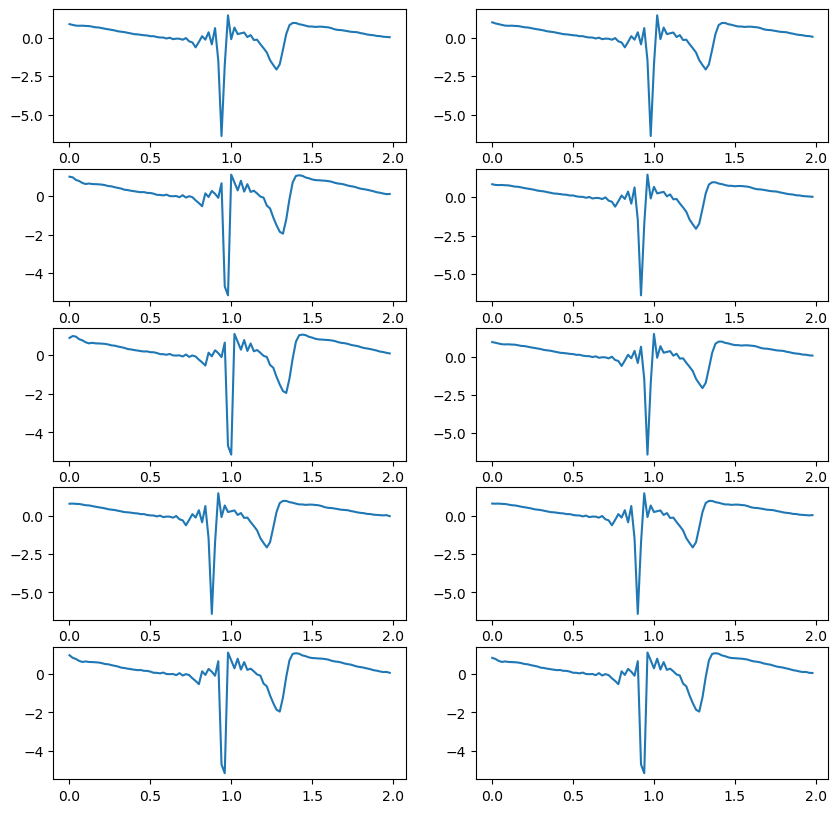

Class:  N3


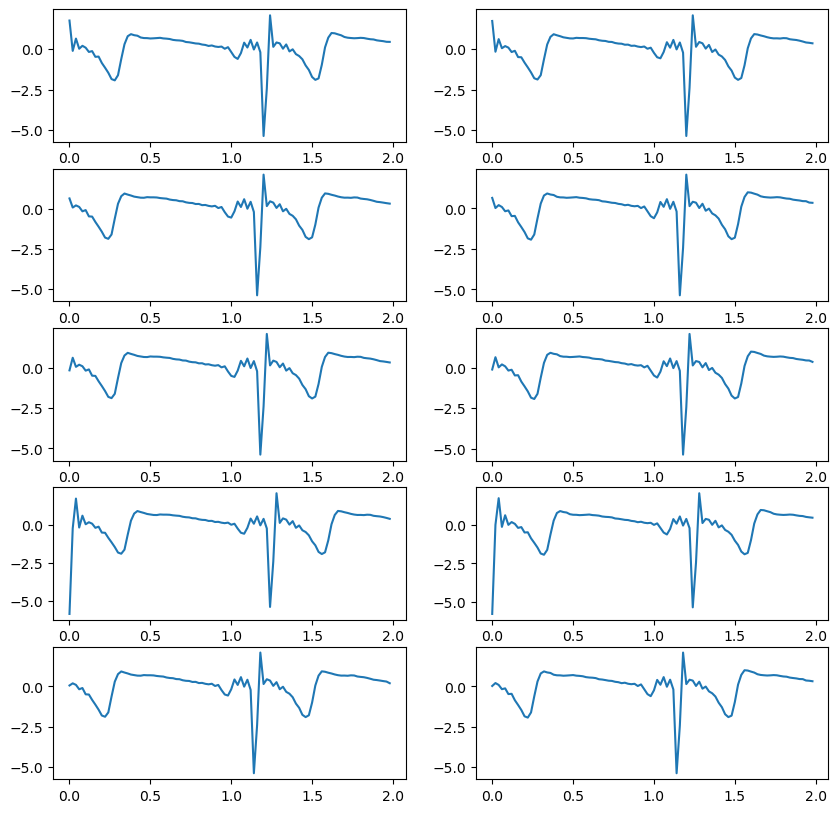

Class:  REM


In [23]:
#Use the code of the motifs seach to find the top-K motifs by class
for class_of_interest in np.unique(gt):
    out_class = out.copy()
    av = np.array(gt == class_of_interest).astype(int)
    #Reshape the av to be able to multiply, since the av is a vector for each 5s, we need to repeat the values for each segment
    av = np.repeat(av, 5*50)
    #Fill the av class padding to have the same size as the out_class
    if len(av) < len(out_class):
        av = np.concatenate((av, np.zeros(len(out_class)-len(av))))
    else:
        av = av[:len(out_class)]

    out_class = out_class + out_class.max()*(1-av[:, np.newaxis])
    #Search for the top 10 motifs and plot
    motifs = np.argsort(out_class[:,0])[0:10]
    fig, axs = plt.subplots(5, 2, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(10):
        axs[i].plot(t,channel[motifs[i]:motifs[i]+segmentation_size])
    plt.show()
    print("Class: ", class_of_interest)

In [12]:
### Using ICA on all channels
num_channels = len(channels)
ica = mne.preprocessing.ICA(n_components=num_channels, random_state=97, max_iter=800)
ica.fit(data)



Fitting ICA to data using 23 channels (please be patient, this may take a while)
Selecting by number: 23 components


C:\Users\rafar\AppData\Local\Temp\ipykernel_34700\3611966243.py:4: RuntimeWarning: Using n_components=23 (resulting in n_components_=23) may lead to an unstable mixing matrix estimation because the ratio between the largest (22) and smallest (3.8e-10) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 16
  ica.fit(data)


Fitting ICA took 730.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,43 iterations on raw data (5768000 samples)
ICA components,23
Available PCA components,23
Channel types,eeg
ICA components marked for exclusion,—


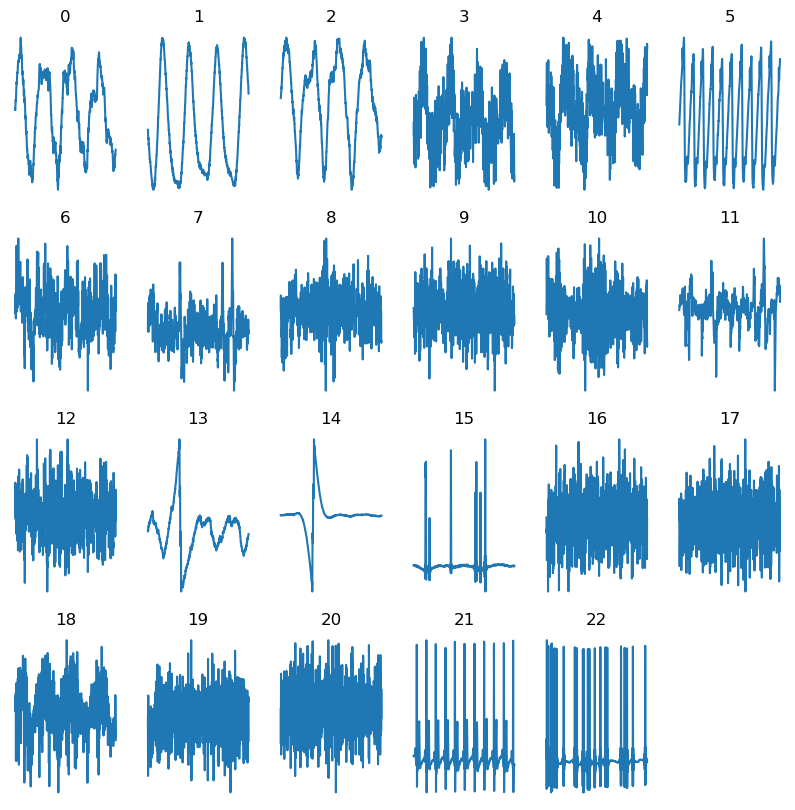

In [13]:
#Get the ICA components and plot it
ica_components = ica.get_sources(data)
ica_components = ica_components.get_data()
#Plot each component on a different subplot, looking only the first 20s
fig, axs = plt.subplots(4, 6, figsize=(10, 10))
axs = axs.ravel()
for i in range(23):
    axs[i].plot(ica_components[i][:int(50*fs)])
    #Put the legend with the number and hidden the axis
    axs[i].set_title(i)
    axs[i].axis('off')
#Remove the remaining subplots
for i in range(23, 24):
    fig.delaxes(axs[i])

plt.show()


In [14]:
remove_components = [22, 21, 13, 14, 15, 11]
ica.exclude = remove_components
#Apply the ICA to the data
data_clean = ica.apply(data)
data_clean = data_clean.get_data()


Applying ICA to Raw instance
    Transforming to ICA space (23 components)
    Zeroing out 6 ICA components
    Projecting back using 23 PCA components


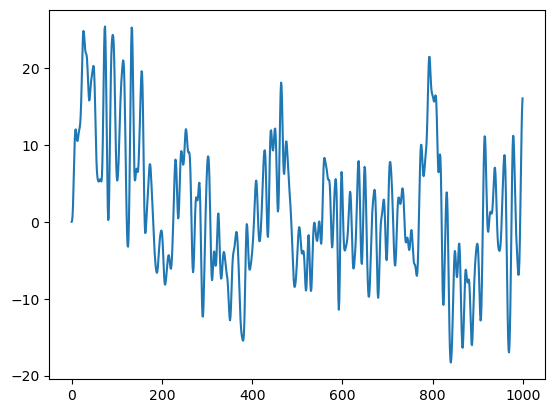

In [15]:
#Plot the data of EOG1 after ICA
channel = data_clean[channels.index('EOG1')]
plt.plot(channel[:int(20*fs)])


In [16]:
#Select the component that looks like with the EEG data
channel = channel[:-offset]

In [17]:
channel.shape

(5678000,)

In [ ]:
#Analysis using matrix profile
import stumpy

segmentation_size = int(fs)
out = stumpy.gpu_stump(channel, m=int(segmentation_size))

In [ ]:
#Plot matrix profile with the ground truth in different subplots
plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.plot(channel)
plt.title("Channel")
plt.subplot(3, 1, 2)
plt.title("Matrix Profile")
plt.plot(out[:, 0])
plt.subplot(3, 1, 3)
plt.title("Annotation")
#Change annotation to the class_name alias
#gt_alias = [class_name_alias[x] for x in gt]
plt.plot(gt)
plt.show()



In [ ]:
#Plot the first 10 motifs
motifs = np.argsort(out[:,0])[0:20]
fig, axs = plt.subplots(5, 4, figsize=(10, 10))
axs = axs.ravel()
for i in range(20):
    axs[i].plot(t,channel[motifs[i]:motifs[i]+segmentation_size])
plt.show()


In [ ]:
#Use the code of the motifs seach to find the top-K motifs by class
for class_of_interest in np.unique(gt):
    out_class = out.copy()
    av = np.array(gt == class_of_interest).astype(int)
    #Reshape the av to be able to multiply, since the av is a vector for each 5s, we need to repeat the values for each segment
    av = np.repeat(av, 5*50)
    #Fill the av class padding to have the same size as the out_class
    if len(av) < len(out_class):
        av = np.concatenate((av, np.zeros(len(out_class)-len(av))))
    else:
        av = av[:len(out_class)]

    out_class = out_class + out_class.max()*(1-av[:, np.newaxis])
    #Search for the top 10 motifs and plot
    motifs = np.argsort(out_class[:,0])[0:10]
    fig, axs = plt.subplots(5, 2, figsize=(10, 10))
    axs = axs.ravel()
    for i in range(10):
        axs[i].plot(t,channel[motifs[i]:motifs[i]+segmentation_size])
    plt.show()
    print("Class: ", class_of_interest)